TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise

Mikael Janhonen  
mijojan@utu.fi

February 2020

---

## Introduction

In this project, we trying to label images into 3 different categories based on their content. The three categories are grass, sand and stairs. We do this by traning different machine learning classifiers for the task.

The images are from https://unsplash.com/

I mainly used the **numpy** and **pandas** libraries for data storage and manipulation.

**skimage** was used for image manipulation, and **sklearn** for the classification models.


I will use K-nearest neighbors, ridge regression (classification) and multi layer perceptron models for the  classification task.

## Data preparation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import resize

from scipy import stats

import imageio
import math

Download the data into pandas dataframe

In [2]:
# Create pandas DataFrame for the image data
data = pd.DataFrame(columns=['url', 'width', 'height', 'color_channels', 'label', 'data'])

# Load all the image files into the dataframe
for label in ['grass', 'sand', 'stairs']:
    file_path = './data/'+label+'.txt'
    image_urls = pd.read_csv(file_path)
    print(f'Downloading {len(image_urls)} image files from urls in {file_path}...')
    
    for url in image_urls.iloc[:, 0]:
        image = imageio.imread(url) # image is an numpy array
        data = data.append({
            'url': url,
            'height': image.shape[0],
            'width': image.shape[1],
            'color_channels': image.shape[2],
            'label': label,
            'data': image,
        }, ignore_index=True)


In [3]:
# Let's take a look at the dimension metadata 
_d = data.drop(['data'], axis=1)
_d['width'] = _d['width'].astype('float')
_d['height'] = _d['height'].astype('float')
_d['color_channels'] = _d['color_channels'].astype('float')
_d.describe()

width       height  color_channels
count   182.0   182.000000           182.0
mean   1000.0  1005.368132             3.0
std       0.0   407.123153             0.0
min    1000.0   465.000000             3.0
25%    1000.0   667.000000             3.0
50%    1000.0   735.500000             3.0
75%    1000.0  1498.000000             3.0
max    1000.0  2171.000000             3.0

All the images have 3 color channels which is as intended.

All the images have have width of 1000, but the height is verying from 465 to 2171. We should make the dimensions match so that it won't cause problems later on. We could crop the images, but then we lose some information. Streching them might also affect the classification, because this might change the features we extract a lot, especially the texture features. Another way might be to copy the content of the smaller images to fill the missing space.

I am going to stretch the images to the average height of all images. (I tested out both cropping and stretching and did not notice remarkable changes in the results. This is also why there are implementations for both cropping and stretching.)

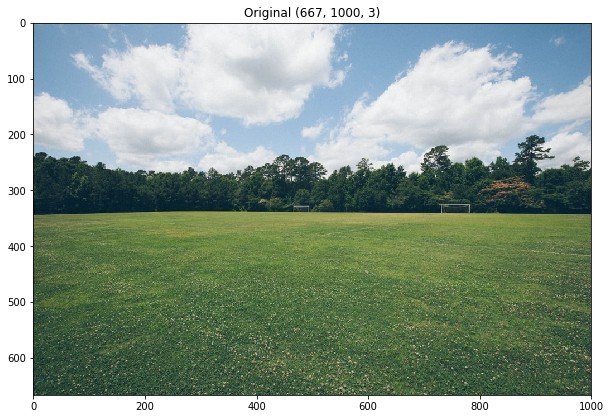

(465, 1000, 3)


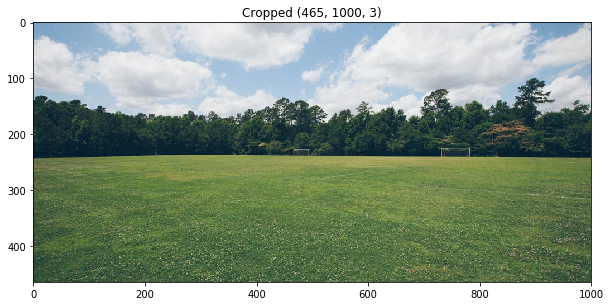

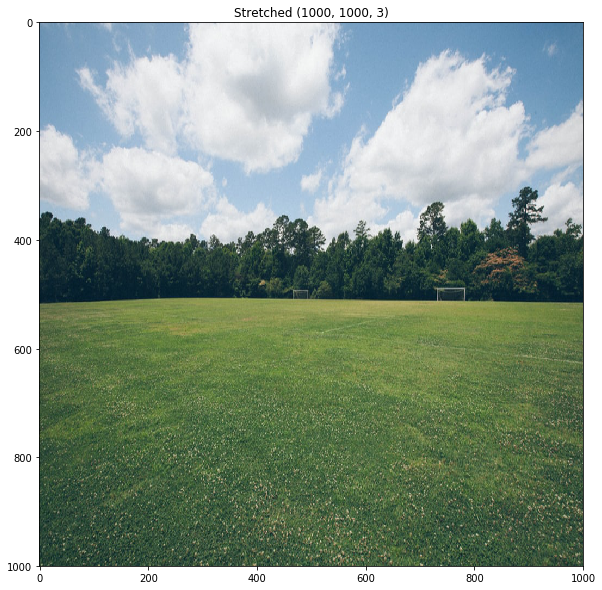

In [4]:
# Implement both the cropping and stretching methods
def crop_image(image_data, target_height):
    height = image_data.shape[0]
    start_y = math.floor((height - target_height) / 2)
    end_y = start_y+target_height
    return image_data[start_y:end_y, :, :]

def stretch_image(image_data, target_height):
    current_width = image_data.shape[1]
    
    # Use the resize method from skimage.transform
    stretched_image = resize(
        image_data,
        (current_width, target_height),
        mode='reflect',
        anti_aliasing=True
    )
    return np.floor(stretched_image * 255).astype(int)
    

# Make sure it works
_t = data.loc[0, 'data']
plt.figure(figsize=(10,10))
plt.imshow(_t)
plt.title('Original ' + str(_t.shape))
plt.show()

_t = crop_image(_t, 465)
print(_t.shape)
plt.figure(figsize=(10,10))
plt.imshow(_t)
plt.title('Cropped ' + str(_t.shape))
plt.show()

# Lets make sure the resizing works also
_t = data.loc[0, 'data']
_t = stretch_image(_t, 1000)
plt.figure(figsize=(10,10))
plt.imshow(_t)
plt.title('Stretched ' + str(_t.shape))
plt.show()

In [5]:
# Stretch all the images to the average height
avg_heigth = round(data['height'].mean())

data['data'] = data['data'].transform(
    lambda d: stretch_image(d, avg_heigth)
)

Next, prepare the data for GLCM and GLRLM by changing the data into grayscale with quantization level of 8.

Implement and test functions for grayscale and quantization transforms.

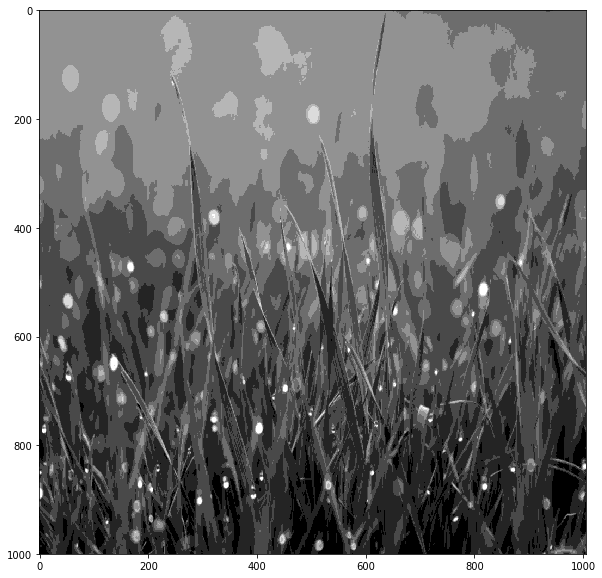

In [6]:


def transform_image_into_grayscale(image_data):
    return np.sum(image_data[:, :, 0:3], axis=2).astype('uint32')

def quantize_grayscale_image(image_data, input_levels, output_levels):
    return np.dot(image_data[:, :], (1/input_levels)*output_levels).astype('uint8')


grayscale_data = data['data']

grayscale_data = grayscale_data.transform(lambda x: transform_image_into_grayscale(x))
plt.figure(figsize=(10,10))
plt.imshow(grayscale_data[3], cmap='gray', vmin=0, vmax=255*3)
plt.show()

grayscale_data = grayscale_data.transform(lambda x: quantize_grayscale_image(x, 255*3, 8))
plt.figure(figsize=(10,10))
plt.imshow(grayscale_data[3], cmap='gray', vmin=0, vmax=7)
plt.show()


Everything seems to be working fine

## Feature extraction

In [7]:
# Create pandas DataFrame to store the features
features = pd.DataFrame()

### First order texture measures (6 features)

Lets calculate the mean and variance features.

In [8]:
features['mean_red'] = data['data'].transform(lambda x: x[:, :, 0].mean())
features['mean_green'] = data['data'].transform(lambda x: x[:, :, 1].mean())
features['mean_blue'] = data['data'].transform(lambda x: x[:, :, 2].mean())

features['variance_red'] = data['data'].transform(lambda x: x[:, :, 0].var())
features['variance_green'] = data['data'].transform(lambda x: x[:, :, 1].var())
features['variance_blue'] = data['data'].transform(lambda x: x[:, :, 2].var())

### Second order texture measures (4 or 10 features)

Calculate the GLCO matrix

In [32]:
# Implement the calculation
def calculate_glco_matrix(grayscale_image_data, distance, angle, quantization_level_count=8):
    assert angle in [0, 45, 90, 135], "Angle must be 0, 45, 90 or 135"
    height = grayscale_image_data.shape[0]
    width = grayscale_image_data.shape[1]

    if angle == 0:
        R = (width - distance) * height * 2    
        range_to_check = (width - distance, height)
        place_to_check = (distance, 0)
        
    if angle == 45:
        R = (width - distance) * (heigth - distance) * 2
        range_to_check = (width - distance, height - distance)
        place_to_check = (distance, distance)
        
    if angle == 90:
        R = (height - distance) * width * 2
        range_to_check = (width, height - distance)
        place_to_check = (0, distance)
        
    if angle == 135:
        R = (width - distance) * (heigth - distance) * 2
        range_to_check = (width - distance, height - distance)
        place_to_check = (-distance, distance)
    
    matrix = np.zeros((quantization_level_count,quantization_level_count))
    
    for i in range(quantization_level_count):
        for j in range(quantization_level_count):

            number_of_matches = 0

            # Go through all the pixels
            for y in range(range_to_check[1]):
                for x in range(range_to_check[0]):

                    if (
                        grayscale_image_data[y,x] == i and
                        grayscale_image_data[y+place_to_check[1], x+place_to_check[0]] == j
                    ):
                        number_of_matches += 1
                        
            matrix[i,j] = number_of_matches / R

    return np.add(matrix, np.transpose(matrix))

def glcm_mean(matrix):
    mean = 0
    for i in range(len(matrix)):
        mean += i * matrix[i, :].sum()
    return mean

def glcm_variance(matrix):
    var = 0
    mean = glcm_mean(matrix)
    for i in range(len(matrix)):
        var += ((i-mean)**2) * matrix[i,:].sum()
    return var

def glcm_correlation(matrix):
    correlation = 0
    mean = glcm_mean(matrix)
    var = glcm_variance(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            correlation += matrix[i,j] * ((i-mean)*(j-mean)) / var
    return correlation


# Test the implementation (using the example from the slides)
_test_array = np.array([
    [0,0,2,2],
    [1,1,0,0],
    [3,2,3,3],
    [3,2,2,2]
])
_glco_matrix = calculate_glco_matrix(_test_array, 1, 0, 4)

print('glco_matrix:')
print(_glco_matrix, '\n')
print('mean: ', glcm_mean(_glco_matrix))
print('variance: ', glcm_variance(_glco_matrix))
print('correlation: ', glcm_correlation(_glco_matrix))


glco_matrix:
[[0.16666667 0.04166667 0.04166667 0.        ]
 [0.04166667 0.08333333 0.         0.        ]
 [0.04166667 0.         0.25       0.125     ]
 [0.         0.         0.125      0.08333333]] 

mean:  1.5833333333333335
variance:  1.159722222222222
correlation:  0.7125748502994014


After testing my implementation, I found it to be very slow for the image data. I found another implementation for calculating the glco matrix and it's features from the skimage library, which probably has a much efficient implementation. I will use that.

https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.greycomatrix

In [10]:
# Lets see that the skimage implementation returns the same result for our test_array
_glco_matrix = greycomatrix(_test_array, [1], [0], levels=4, symmetric=True, normed=True)

print('glco_matrix:')
print(_glco_matrix[:,:,0,0], '\n')
print('mean: ', glcm_mean(_glco_matrix[:,:,0,0]))
print('variance: ', glcm_variance(_glco_matrix[:,:,0,0]))
print('correlation: ', greycoprops(_glco_matrix, prop='correlation')[0,0])



glco_matrix:
[[0.16666667 0.04166667 0.04166667 0.        ]
 [0.04166667 0.08333333 0.         0.        ]
 [0.04166667 0.         0.25       0.125     ]
 [0.         0.         0.125      0.08333333]] 

mean:  1.5833333333333335
variance:  1.159722222222222
correlation:  0.7125748502994013


I will calculate the glcm correlation for horizontal (angle=0) and vertical (angle=90) directions for distances 5 and 50. I think these distances will detect different kinds of textures. The 5 will detect a much smaller scale texture smoothness, and the 50 will detech larger scale patterns.

In [11]:
distances = [5, 50]
angles = [0, math.pi/2]

for i, image in enumerate(grayscale_data, start=0):
    matrices = greycomatrix(image, distances, angles, levels=8, symmetric=True, normed=True)
    correlations = greycoprops(matrices, prop='correlation')
    features.loc[i, 'glcm_correlation_h5'] = correlations[0, 0]
    features.loc[i, 'glcm_correlation_h50'] = correlations[1, 0]
    features.loc[i, 'glcm_correlation_v5'] = correlations[0, 1]
    features.loc[i, 'glcm_correlation_v50'] = correlations[1, 1]


In [12]:
# Lets take a look at our features
features.describe()

mean_red  mean_green   mean_blue  variance_red  variance_green  \
count  182.000000  182.000000  182.000000    182.000000      182.000000   
mean   124.018656  124.796968   99.794823   2532.636952     2310.555108   
std     48.635655   40.703013   49.316628   1740.212188     1560.047663   
min      8.631639   34.431280    8.866153     21.345972       27.592643   
25%     87.555024   92.160428   64.669645   1149.173779     1109.561486   
50%    126.343132  120.546281   93.975171   2303.836354     2081.343653   
75%    155.579253  153.634159  135.425106   3554.563495     3360.194505   
max    249.208103  231.693784  227.076586   9355.538835    10073.219632   

       variance_blue  glcm_correlation_h5  glcm_correlation_h50  \
count     182.000000           182.000000            182.000000   
mean     2619.912675             0.803831              0.572945   
std      2488.567584             0.194876              0.285168   
min        35.584567             0.022685             -0.449780   
25%       802.070174             0.739696              0.370308   
50%      1757.415741             0.879300              0.633863   
75%      3878.284692             0.936946              0.815728   
max     12975.467155             0.994770              0.976955   

       glcm_correlation_v5  glcm_correlation_v50  
count           182.000000            182.000000  
mean              0.787323              0.494210  
std               0.195615              0.245341  
min               0.033775             -0.433467  
25%               0.724525              0.323980  
50%               0.865209              0.547061  
75%               0.918360              0.695495  
max               0.991476              0.920824

In [13]:
# Standardize the features
features = (features-features.mean())/features.std()
features.describe()

mean_red    mean_green     mean_blue  variance_red  variance_green  \
count  1.820000e+02  1.820000e+02  1.820000e+02  1.820000e+02    1.820000e+02   
mean   1.119678e-15 -3.233067e-16  5.461901e-16 -3.904081e-17   -8.052167e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
min   -2.372478e+00 -2.220123e+00 -1.843773e+00 -1.443095e+00   -1.463393e+00   
25%   -7.497305e-01 -8.018213e-01 -7.122380e-01 -7.949968e-01   -7.698442e-01   
50%    4.779365e-02 -1.044318e-01 -1.180059e-01 -1.314786e-01   -1.469259e-01   
75%    6.489189e-01  7.084780e-01  7.224801e-01  5.872425e-01    6.728252e-01   
max    2.574026e+00  2.626263e+00  2.580910e+00  3.920730e+00    4.975915e+00   

       variance_blue  glcm_correlation_h5  glcm_correlation_h50  \
count   1.820000e+02         1.820000e+02          1.820000e+02   
mean    9.229491e-16         1.958141e-15          2.845709e-16   
std     1.000000e+00         1.000000e+00          1.000000e+00   
min    -1.038480e+00        -4.008419e+00         -3.586401e+00   
25%    -7.304774e-01        -3.291065e-01         -7.105900e-01   
50%    -3.465837e-01         3.872675e-01          2.136213e-01   
75%     5.056612e-01         6.830771e-01          8.513719e-01   
max     4.161251e+00         9.797959e-01          1.416746e+00   

       glcm_correlation_v5  glcm_correlation_v50  
count         1.820000e+02          1.820000e+02  
mean          3.610207e-15          2.065846e-16  
std           1.000000e+00          1.000000e+00  
min          -3.852207e+00         -3.781183e+00  
25%          -3.210299e-01         -6.938517e-01  
50%           3.981574e-01          2.154185e-01  
75%           6.698709e-01          8.204322e-01  
max           1.043648e+00          1.738866e+00

In [14]:
# Create input array X and output result array Y
X = features.values

# Transform the labels into numerical data (int)
# Store the conversion in label_index
label_index = {
    'grass': 0,
    'sand': 1,
    'stairs': 2,
    0: 'grass',
    1: 'sand',
    2: 'stairs',
}

y = data['label'].transform(lambda l: label_index[l]).values

## Feature relationships

Make illustrations of the feature relationships, and discuss the results

### Pairplot

- Pairplot **(1 p)**
    - Which feature pairs possess roughly linear dependence?

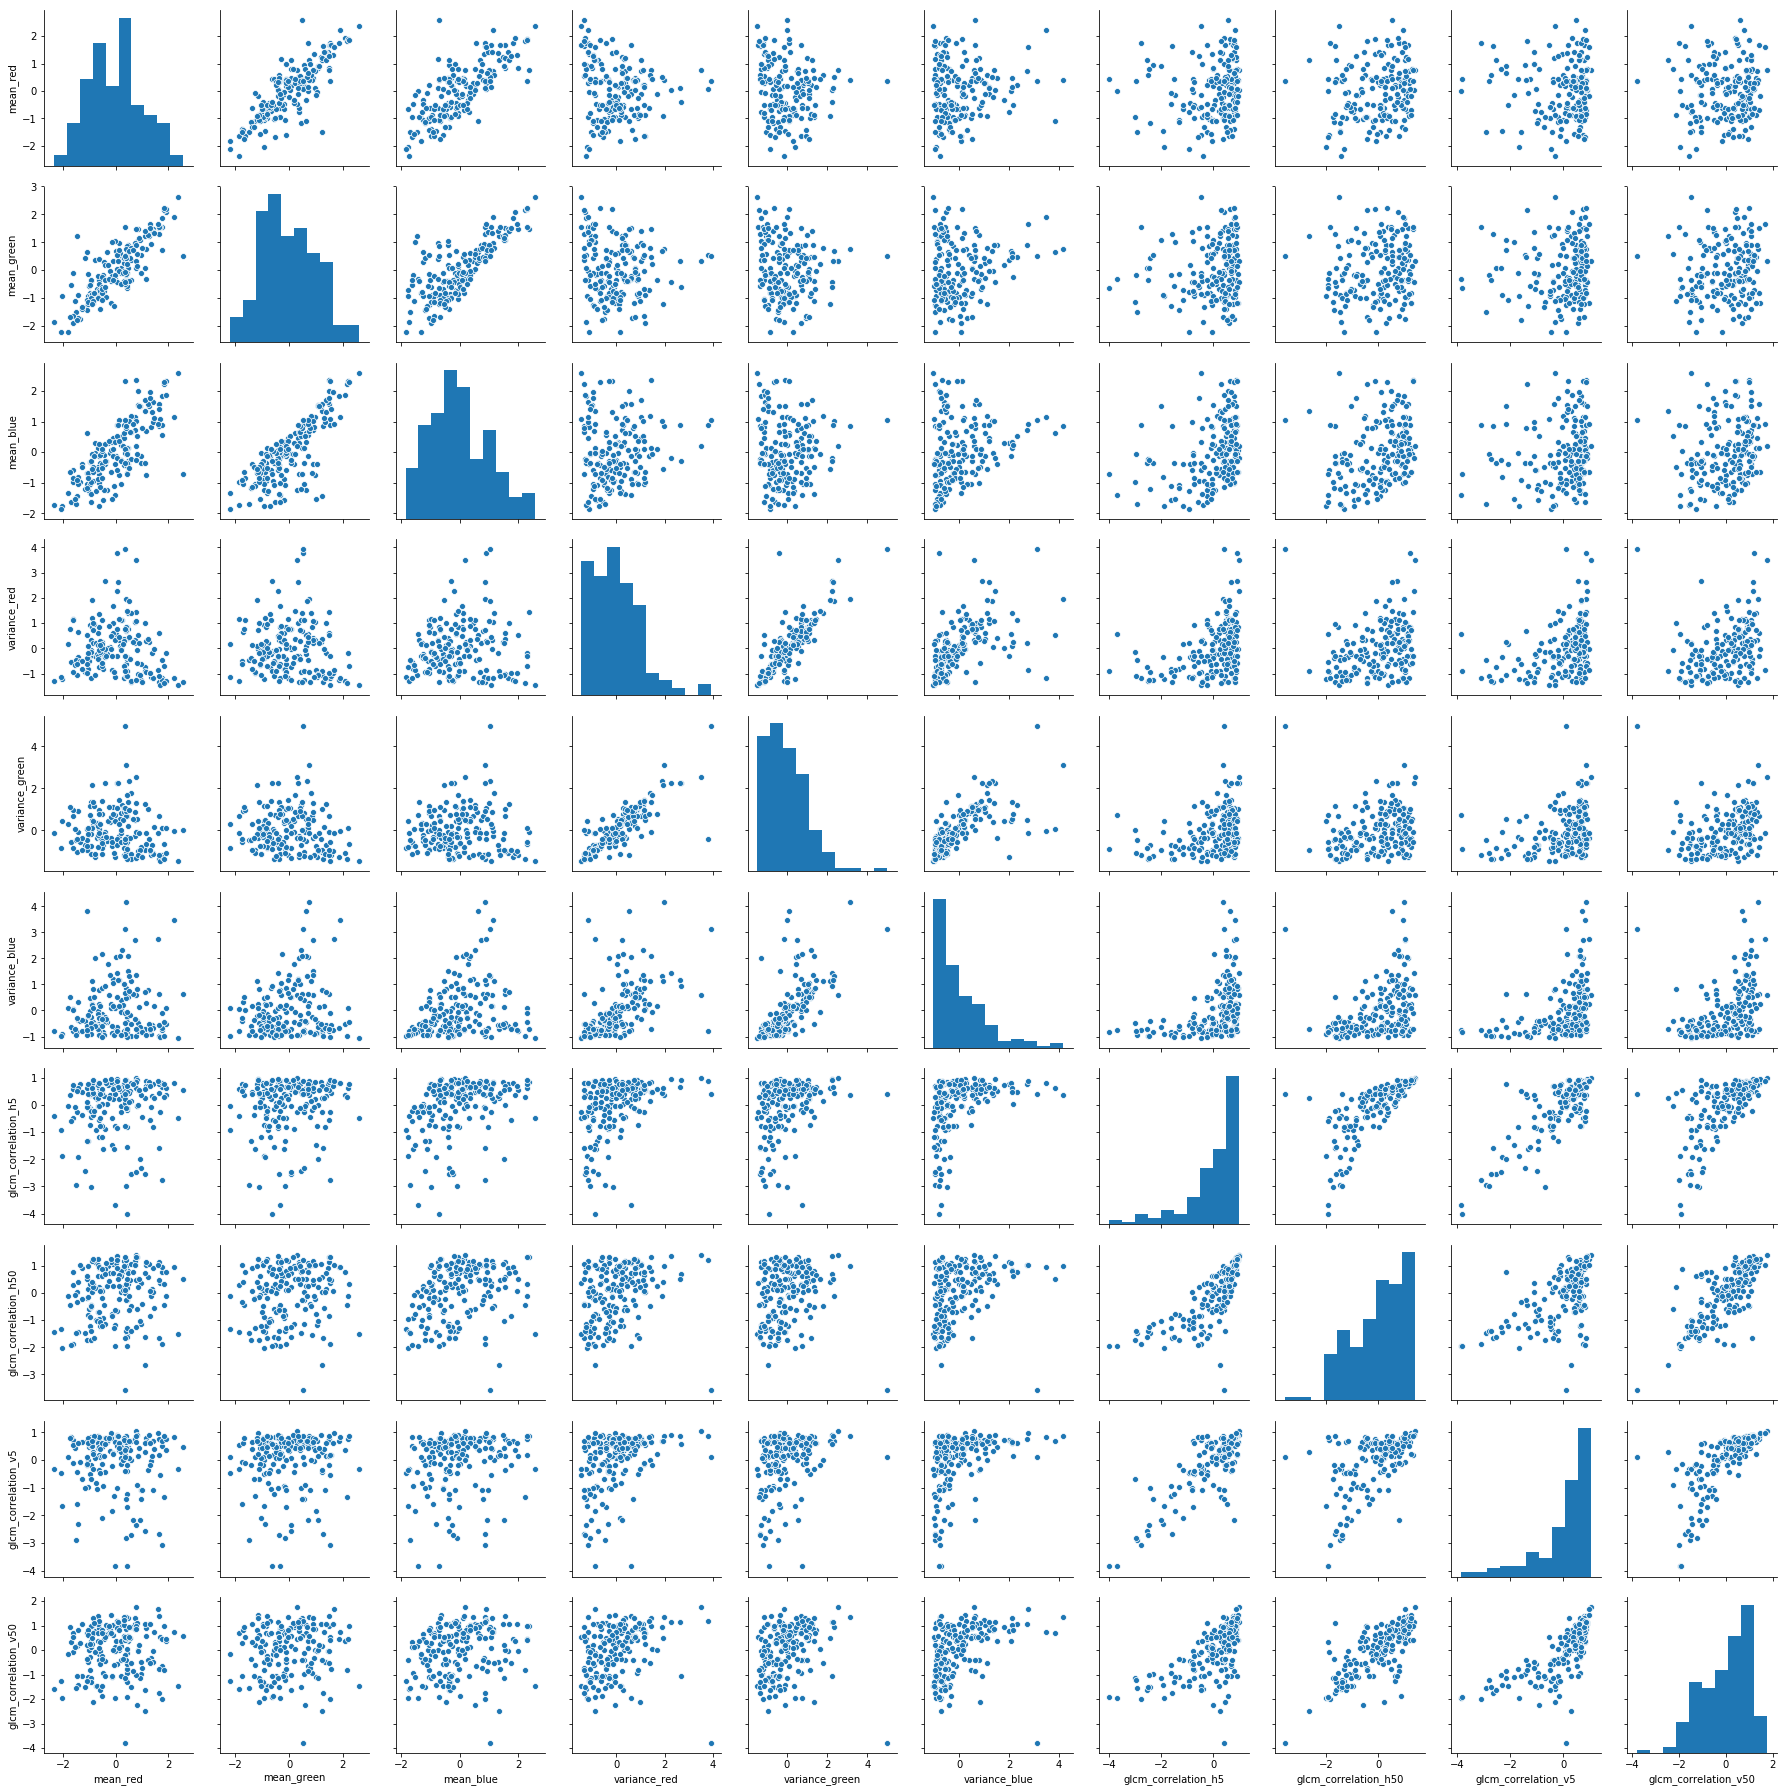

In [15]:
sns.pairplot(features)

The means for the different color channels seem to be quite strongly correlated. Makes sense as the image data we have is real life imagery where the colors are not highly color saturated, and are much more likely to use shades where the value for the color channels are close to each other rather that far apart.

The variances for color channels are skewed left, because it is rare for the images to contain a lot of variance for a color. They also seem to be correlated with each other quite highly.

The gfcm_correlations for the different distance and angles are also correlated with each other.

### PCA

In [16]:
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X)

_cumsum = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

for i, c in enumerate(_cumsum):
    print(f'Components: {i},   explained variance: {c}')
    
plt.figure(figsize=(8,6))
fig = sns.lineplot(x=range(X.shape[1]+1), y=_cumsum)
fig.set(title="Cumulative explained variance ratio")
fig.set_xlabel('number of PCA components')
plt.show()


plt.figure(figsize=(8,8))
fig = sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=X_pca[:, 2],
    palette=sns.cubehelix_palette(start=3, rot=.8, hue=.8, dark=0, light=.7, as_cmap=True),
    edgecolor="none",
)
fig.set(title="First 3 princible components")
fig.set_xlabel('1. princible component')
fig.set_ylabel('2. princible component')
plt.show()

                      

Components: 0,   explained variance: 0.0
Components: 1,   explained variance: 0.41139321289698183
Components: 2,   explained variance: 0.671474554801923
Components: 3,   explained variance: 0.823093648339391
Components: 4,   explained variance: 0.8716547965862885
Components: 5,   explained variance: 0.9122609079765178
Components: 6,   explained variance: 0.9458587940877385
Components: 7,   explained variance: 0.9668571349867415
Components: 8,   explained variance: 0.9822480026186085
Components: 9,   explained variance: 0.9926053193927842
Components: 10,   explained variance: 1.0


The first 2 princible components are clearly not uniformly distributed, there is some clustering in some parts of the diagram. But there are no very clear clusters. If we would see 3 distinct clusters in our 2D PCA image, it would indicate that the three different classes we have can be clearly separated. As this is not the case, the labeling might be more tricky and might depend on more abstract and non-linear connections.

As expected, explained variance jumps greatly during the first couple of PCA features, and then the growth declines towards the latter ones. But it still keeps increasing during the later features, which means that they still provide more information (at least in linear pca sense). I think this is a good result, which means that we have picked good features, that are not too much correlated with each other.

## Build classifiers and estimate their performance

### kNN

Lets implement the inner cross validation for the K Nearest Neighbors classifier. The knn_inner function will find the parameter (n_neigthbors) that grants the best possible accuracy.

In [17]:
# Lets create the inner cross validation, which calculates the performance for the n_neighbors parameter
def knn_inner(X, y, n_neighbors_range=range(1,20), n_splits=20):
    
    parameter_performance = pd.DataFrame({
        'n_neighbors': n_neighbors_range
    })

    for index, parameters in parameter_performance.iterrows():
        kfold = KFold(n_splits=n_splits)

        scores = []

        for train, test in kfold.split(X):
            knn = KNeighborsClassifier(n_neighbors=parameters['n_neighbors'])
            knn.fit(X[train], y[train])
            scores.append(knn.score(X[test], y[test]))

        parameter_performance.loc[index, 'accuracy'] = np.mean(scores)
        
    return parameter_performance


Lets tests the effects of the n_neighbors parameter on the accuracy. 

In [18]:
plt.figure(figsize=(10,8))
for x in range(10):
    _X = np.copy(X)
    _y = np.copy(y)

    # Shuffle the data in unison
    perm = np.random.permutation(len(_X))
    _X = _X[perm]
    _y = _y[perm]

    _knn_parameter_performance = knn_inner(_X, _y, n_neighbors_range=range(1, 50))
    fig = sns.lineplot(x='n_neighbors', y='accuracy', data=_knn_parameter_performance)
    
fig.set(xlabel='n_neighbors', ylabel='Accuracy', title='n_neighbors effects on accuracy')
plt.show()

We can see from this diagram, that the KFold cross validation introduces some randomness to the results, due to the random shuffle of the input data. Larger number of n_folds would decrease this randomness.

We can see from the graph that the highes point for the accuracy seems to be somewhere near 10 neighbors.

Implment the outer cross validation for ridge regression. The outer CV uses the inner one to find the best parameters for the train set, and then evaluates the performance on the test set. It returns both the accuracy (successful prediction / all predictions) and the confusion matrix.


In [19]:
def knn_outer(X, y, n_splits=20):
    kfold = KFold(n_splits=n_splits)
    
    confusion_matrix = np.zeros((3,3))
    
    for train, test in kfold.split(X):
        
        # Calculate the accuracy for different parameter configurations with the knn_inner function
        parameters = knn_inner(X[train], y[train], n_splits=n_splits, n_neighbors_range=range(1,20))
        
        # Select the best parameters
        best_parameters = parameters.loc[parameters['accuracy'] == parameters['accuracy'].max(), :].iloc[0]
        
        # Train a model with the best parameters
        knn = KNeighborsClassifier(n_neighbors=best_parameters['n_neighbors'].astype('int'))
        knn.fit(X[train], y[train])
        predictions = knn.predict(X[test])
        for (prediction, real) in zip(predictions, y[test]):
            confusion_matrix[real, prediction] = confusion_matrix[real, prediction] + 1
        
    correct_predictions = 0
    for i in range(len(confusion_matrix)):
        correct_predictions += confusion_matrix[i,i]
        
    accuracy = correct_predictions / np.sum(confusion_matrix)
    
    return accuracy, confusion_matrix


Calculate the KNN performance

In [20]:
_X = np.copy(X)
_y = np.copy(y)

# Shuffle the data in unison
perm = np.random.permutation(len(_X))
_X = _X[perm]
_y = _y[perm]

accuracy, confusion_matrix = knn_outer(_X, _y, n_splits=50)
print('accuracy:', accuracy)
print('confusion_matrix:')
print(confusion_matrix)

accuracy: 0.6813186813186813
confusion_matrix:
[[47.  7.  7.]
 [ 8. 43.  9.]
 [ 9. 18. 34.]]


The accuracy is about ~0.73 in my runs. There is still some variance in the results due to the randomness in the KFold crossvalidation splits.

### Ridge regression

Lets implement the inner cross validation for Ridge Regression. The ridge_inner function will find the parameter (alpha_range) that grants the best possible accuracy.

In [21]:
# Lets create the inner cross validation for ridge regression, which calculates the performance for the ridge alpha parameter
def ridge_inner(X, y, alpha_range=[.001, .01, .1, .5, 1., 2., 5., 10., 100., 1000.], n_splits=20):
    
    parameter_performance = pd.DataFrame({
        'alpha': alpha_range
    })

    for index, parameters in parameter_performance.iterrows():
        kfold = KFold(n_splits=n_splits)

        scores = []

        for train, test in kfold.split(X):
            ridge = RidgeClassifier(alpha=parameters['alpha'])
            ridge.fit(X[train], y[train])
            scores.append(ridge.score(X[test], y[test]))

        parameter_performance.loc[index, 'accuracy'] = np.mean(scores)
        
    return parameter_performance


Lets tests the effects of the alpha parameter on the accuracy.

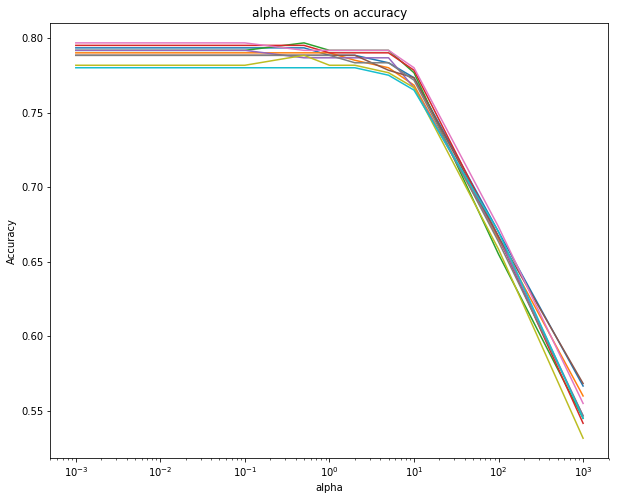

In [22]:
# Lets just test the parameters effect for the predictions for the whole data
plt.figure(figsize=(10,8))
plt.xscale('log')
for x in range(10):
    _X = np.copy(X)
    _y = np.copy(y)

    # Shuffle the data in unison
    perm = np.random.permutation(len(_X))
    _X = _X[perm]
    _y = _y[perm]

    _ridge_parameter_performance = ridge_inner(
        _X, _y, alpha_range=[.001, .01, .1, .5, 1., 2., 5., 10., 100., 1000.], n_splits=50
    )
    fig = sns.lineplot(x='alpha', y='accuracy', data=_ridge_parameter_performance)
fig.set(xlabel='alpha', ylabel='Accuracy', title='alpha effects on accuracy')
plt.show()

The accuracy drops as the alpha value gets higher, but there is no clear peek to it.

Implment the outer cross validation for ridge regression. The outer CV uses the inner one to find the best parameters for the train set, and then evaluates the performance on the test set.

In [23]:
def ridge_outer(X, y, n_splits=20):
    kfold = KFold(n_splits=n_splits)
    
    confusion_matrix = np.zeros((3,3))
    
    for train, test in kfold.split(X):
        
        # Calculate the accuracy for different parameter configurations with the knn_inner function
        parameters = ridge_inner(X[train], y[train], n_splits=n_splits)
        
        # Select the best parameters
        best_parameters = parameters.loc[parameters['accuracy'] == parameters['accuracy'].max(), :].iloc[0]
        
        # Train a model with the best parameters
        ridge = RidgeClassifier(alpha=best_parameters['alpha'])
        ridge.fit(X[train], y[train])
        predictions = ridge.predict(X[test])
        for (prediction, real) in zip(predictions, y[test]):
            confusion_matrix[real, prediction] = confusion_matrix[real, prediction] + 1
        
    correct_predictions = 0
    for i in range(len(confusion_matrix)):
        correct_predictions += confusion_matrix[i,i]
        
    accuracy = correct_predictions / np.sum(confusion_matrix)
    
    return accuracy, confusion_matrix

Calculate the expected performance for ridge_regression

In [24]:
_X = np.copy(X)
_y = np.copy(y)

# Shuffle the data in unison
perm = np.random.permutation(len(_X))
_X = _X[perm]
_y = _y[perm]

accuracy, confusion_matrix = knn_outer(_X, _y, n_splits=50)
print('accuracy:', accuracy)
print('confusion_matrix:')
print(confusion_matrix)

accuracy: 0.6703296703296703
confusion_matrix:
[[47.  6.  8.]
 [ 6. 42. 12.]
 [12. 16. 33.]]


The accuracy is ~0.71. It is a bit less than with the KNN classifier.

 ### Multi-layer perceptron

I will use the MLPClassifier from the sklearn.neural_network library. I set the early_stopping parameter to True, which means that the classifier will automatically set 10% of the training data as validation data, and will stop the learning once the validation score for that data does not improve anymore.

Lets tests the MLPClassifier in a simple test to see the improvement of the validation_scores.

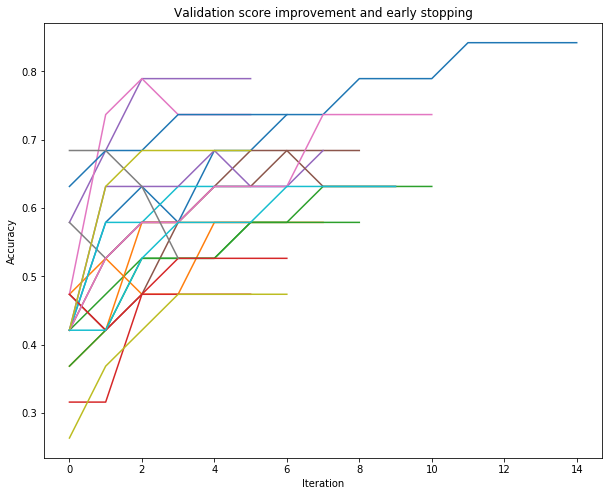

In [25]:
# Test the MLPClassifier in early stopping mode
_X = np.copy(X)
_y = np.copy(y)

plt.figure(figsize=(10,8))
for i in range(20):
    perm = np.random.permutation(len(_X))
    _X = _X[perm]
    _y = _y[perm]

    _mlpc = MLPClassifier(
        hidden_layer_sizes=(1000,),
        early_stopping=True
    )
    _mlpc.fit(_X, _y)

    fig = sns.lineplot(
        x=range(len(_mlpc.validation_scores_)),
        y=_mlpc.validation_scores_,
    )
    
fig.set(xlabel='Iteration', ylabel='Accuracy', title='Validation score improvement and early stopping')
plt.show()

From this diagram we can see the early stopping in action, as the accuracy tends to rise on the further iterations, but stops at some value where we also stop the training.

As we can see, there is a huge amount of variance between the different neural network runs. This is due to the randomly selected 10% of validation data. As our dataset is quite small, there is a huge amount of randomness in the way we select our 10% of validation data (182 / 10 ~= 18 samples). If the samples chosen for validation are the tough ones, we can see very bad performance of about 0.33, which is the same as picking a label at random.

Next lets see how the validation performace depends on the amount of hidden neurons.


In [26]:
def mlpc_parameter_performance(X, y, hidden_neurons_range=range(3,10), n_splits=5):
    
    parameter_performance = []
    
    for hidden_neurons in hidden_neurons_range:

        mlpc = MLPClassifier(
            hidden_layer_sizes=(hidden_neurons,),
            early_stopping=True
        )
        mlpc.fit(X, y)
        parameter_performance.append({
            'hidden_neurons': hidden_neurons,
            'validation_scores': mlpc.validation_scores_,
        })
        
    return parameter_performance


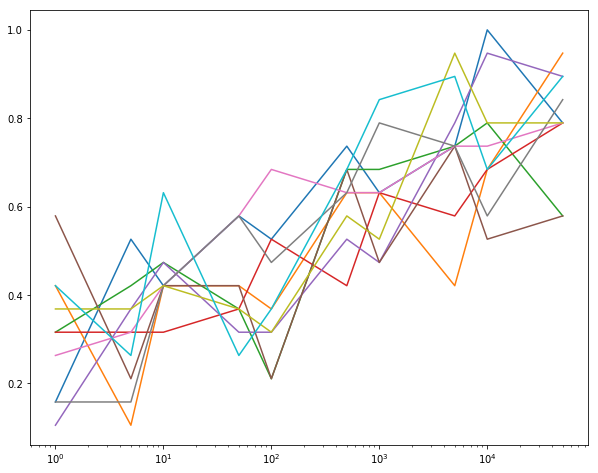

In [27]:
# Lets just test the parameters effect for the predictions for the whole data
plt.figure(figsize=(10,8))
plt.xscale('log')
for x in range(10):
    _X = np.copy(X)
    _y = np.copy(y)

    # Shuffle the data in unison
    perm = np.random.permutation(len(_X))
    _X = _X[perm]
    _y = _y[perm]

    _hidden_neurons_range = [1,5,10,50,100,500,1000,5000,10000,50000]
    _mlpc_parameter_performance = mlpc_parameter_performance(
        _X, _y, hidden_neurons_range=_hidden_neurons_range
    )
    fig = sns.lineplot(
        x=list(map(lambda x : x["hidden_neurons"], _mlpc_parameter_performance)),
        y=list(map(lambda x : max(x["validation_scores"]), _mlpc_parameter_performance))
    )
plt.show()

The accuracy keeps rising even up to 5000 neurons.

Implement the outer CV for multilayer perceptron classifier.

In [28]:
def mlpc_outer(X, y, number_of_classifiers=5, number_of_neurons=10000, n_splits=5, bag_size=0.5):

    kfold = KFold(n_splits=n_splits)
    
    confusion_matrix = np.zeros((3,3))
    
    for train, test in kfold.split(X):

        classifiers = []
        for network_i in range(number_of_classifiers):
            
            # Use bagging for resampling the data for the different classifiers
            selected_indicies = np.random.randint(len(train), size=round(len(train) * bag_size))
            X_sample = np.take(X[train], selected_indicies, axis=0)
            y_sample = np.take(y[train], selected_indicies, axis=0)
            
            classifier = MLPClassifier(
                hidden_layer_sizes=(number_of_neurons,),
                early_stopping=True,
            )
            classifier.fit(X_sample, y_sample)
            classifiers.append(classifier)

        predictions = []
        for classifier in classifiers:
            predictions.append(classifier.predict(X[test]))
        
        # Use the mode as our prediction
        committee_predictions = stats.mode(np.array(predictions))[0][0]
        
        for (prediction, real) in zip(committee_predictions, y[test]):
            confusion_matrix[real, prediction] = confusion_matrix[real, prediction] + 1

    correct_predictions = 0
    for i in range(len(confusion_matrix)):
        correct_predictions += confusion_matrix[i,i]
        
    accuracy = correct_predictions / np.sum(confusion_matrix)
    return accuracy, confusion_matrix        

Test the performance.

In [29]:
_X = np.copy(X)
_y = np.copy(y)

# Shuffle the data in unison
perm = np.random.permutation(len(_X))
_X = _X[perm]
_y = _y[perm]

accuracy, confusion_matrix = mlpc_outer(_X, _y, number_of_classifiers=15, number_of_neurons=5000, n_splits=10, bag_size=.5)
print('accuracy:', accuracy)
print('confusion_matrix:')
print(confusion_matrix)

accuracy: 0.6208791208791209
confusion_matrix:
[[36.  6. 19.]
 [ 7. 44.  9.]
 [13. 15. 33.]]


The accuracy is quite low ~0.61, lower than the other methods.
There seems to be a lot of variance in the results, due to the random way that the KFold cross validation splits the data, and the way the MLPClassifier selects its validation data. Lets run the model multiple times and see the distribution of the results.

Lets see how hyperparameters (number_of_classifiers, bag_size) effect the accuracy.


In [30]:
numbers_of_classifiers = [1, 3, 5, 9, 13, 17]
accuracy_results = []
for noc in numbers_of_classifiers:
    [accuracy, matrix] = mlpc_outer(
        _X,
        _y,
        number_of_classifiers=noc,
        number_of_neurons=5000,
        n_splits=10,
        bag_size=.5
    )
    accuracy_results.append(accuracy)

plt.figure(figsize=(10,8))
fig = sns.lineplot(
    x=numbers_of_classifiers,
    y=accuracy_results
)
fig.set(xlabel='Number of classifiers', ylabel='Accuracy', title='Number of classifiers effects on accuracy')
plt.show()

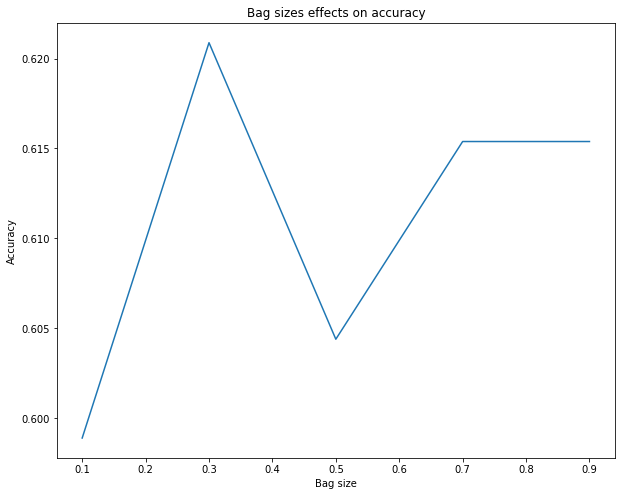

In [31]:
bag_sizes = [.1, .3, .5, .7, .9]
accuracy_results = []
for bag_size in bag_sizes:
    [accuracy, matrix] = mlpc_outer(
        _X,
        _y,
        number_of_classifiers=15,
        number_of_neurons=5000,
        n_splits=10,
        bag_size=bag_size
    )
    accuracy_results.append(accuracy)

plt.figure(figsize=(10,8))
fig = sns.lineplot(
    x=bag_sizes,
    y=accuracy_results
)
fig.set(xlabel='Bag size', ylabel='Accuracy', title='Bag sizes effects on accuracy')
plt.show()

I think these results are quite hard to analyse due to variance in the nature of our cross validation and model tuning setup.

## Discussion

In my results, the KNN classifier worked the best with accuracy of about 0.72. The Ridge Regression got pretty similar results.

I would have expected to get much higher results. 0.72 still clearly means that the classifiers have learned a lot about the data, as a random guess would only grant 0.33 of accuracy. But there are a still a lot of missclassifications.

The first time I was a bit worried about the performance, was when I looked at the PCA results. There are no clear clusters in the first 3 PCA components.

I did not get great results from the neural network. I'm not sure if I have done the early stopping and decision by committee the correct way. The early stopping takes 10% of the data as validation data, which means we have less training data, and hinders the results. The results could have been better with higher number of hidden neurons, but the computational times got too hard to handle. And I feel like 5000 neurons would be high enough to provide enought complexity. Maybe by adding another hidden layer I could have gotten better results.

I think the dataset size is quite limiting, as it is quite small compared to all the variance in the data. The images are very different from each other. I also think I could extract better features from the images. For the Gray Level Co-occurance features, I did not test the effects of different distances and angles on the results. By selecting these paramenters based on the performance, the accuracies could get higher. I think the bonus features I did not extract could have also provided a lot more useful information.